In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/toxic-comment-classification-dataset/test.csv
/kaggle/input/glove6b50d/glove.6B.50d.txt


In [2]:
train=pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [3]:
def OR(a, b, c, d ): 
    return a or b or c or d

train['toxic_all'] = train.apply(lambda row : OR(row['toxic'],row['severe_toxic'],row['obscene'], row['threat']), axis = 1)
    

Text(0.5, 1.0, 'Count of labels')

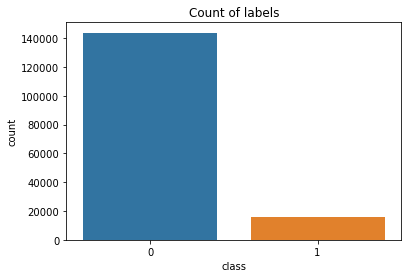

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(train.toxic_all)
plt.xlabel('class')
plt.title('Count of labels')

In [5]:
a=list(train.toxic_all)
print("Toxic Data Percentile :",100*(a.count(1)/(a.count(1)+a.count(0))),"%") 

Toxic Data Percentile : 9.927869099021752 %


**DATA IS IMBALANCED**

**GLOVE**

In [6]:
path = '../input/glove6b50d/'
EMBEDDING_FILE=f'{path}glove.6B.50d'


In [7]:
import codecs

In [8]:
def load_glove_model(glove_file):
    f = codecs.open(glove_file + ".txt", 'r', encoding='utf-8')
    model = {}
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
    return model

In [9]:
model = load_glove_model(EMBEDDING_FILE)

In [10]:
len(model)

400000

In [11]:
def get_w2v(sentence, model):
    vectors= np.array([model.get(val, np.zeros(50)) for val in sentence.split()], dtype=np.float64)
    sum=np.zeros(50,)
    i=0
    for vec in vectors:
        i+=1
        sum+=vec
    sum=sum/i
    return sum.reshape(1,50)

In [12]:
embedding_metrix=[]
for i in range(len(train['comment_text'])):
    a=get_w2v(train['comment_text'][i], model)
    embedding_metrix.append(a[0])

In [13]:
X=embedding_metrix
y=train['toxic_all']

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [17]:
import imblearn
print(imblearn.__version__)
# transform the dataset
oversample = imblearn.over_sampling.SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

Using TensorFlow backend.


0.6.2


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.1, solver='sag')
clf.fit(X,y)
predicted_res=clf.predict(X_test)
accuracy=accuracy_score(y_test,predicted_res)
print(accuracy)
   

0.8146541999849598


In [19]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,predicted_res)
print(accuracy)

0.8146541999849598


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted_res)

array([[29369,  6574],
       [  820,  3130]])

In [21]:
from sklearn.linear_model import SGDClassifier
SGDC=SGDClassifier(alpha=0.0001,loss='hinge')
SGDC.fit(X,y)
predicted_res=SGDC.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,predicted_res)
print(accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted_res)

In [ ]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv=10) 
lin_rmse_scores = np.sqrt(-lin_scores) 


In [ ]:
def display_scores(scores): 
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(lin_rmse_scores) 

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,predicted_res)

In [ ]:
import nltk
tk=nltk.tokenize.TreebankWordTokenizer()
comment_tokens = [tk.tokenize(sent) for sent in train['comment_text']]

In [ ]:
from nltk.corpus import stopwords
for i in range(len(comment_tokens)):
    comment_tokens[i] = [w for w in comment_tokens[i] if w not in stopwords.words('english')]

In [ ]:
from gensim.models import Word2Vec

word2vec = Word2Vec(comment_tokens, min_count=1,size=300)

In [ ]:
vocabulary = word2vec.wv.vocab
len(vocabulary)

In [ ]:
word2vec.save("my_word2vec.model")

In [ ]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 300 dimensions
word_vectors = [word2vec[w] for w in list(word2vec.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(word2vec.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in word2vec.wv.vocab]
    print(doc)
    return np.mean(word2vec[doc], axis=0)

In [ ]:
list_w2v=[]
for x in comment_tokens:
    vec= document_vector(x)
    list_w2v.append(vec)

In [ ]:
import pickle

with open("w2v_list.txt", "wb") as fp:   #Pickling
    pickle.dump(list_w2v, fp)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(list_w2v, train['toxic_all'])